In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
MIN_TIME = 7
DO_KALMAN = True
np.random.seed(3)

def model(prev_state: float) -> float:
    return 0.98 * prev_state


def measurement(state: float) -> float:
    return state


STEPS = 20

actual_state = np.zeros(STEPS)
actual_state[0] = 5

estimated_state = np.zeros(STEPS)
estimated_state_std = np.zeros(STEPS)
estimated_state[0] = 5
estimated_state_std[0] = 0

expected_state = np.zeros(STEPS)
expected_state_std = np.zeros(STEPS)

process_std = 0.3
meas_std = 0.8

obs = np.zeros(STEPS)
gain = np.zeros(STEPS)

for i in range(1, STEPS):
    # Simulate real process
    actual_state[i] = model(actual_state[i - 1]) + process_std * np.random.randn()
    obs[i] = measurement(actual_state[i]) + meas_std * np.random.randn()

    # Filter
    expected_state[i] = model(estimated_state[i - 1])
    expected_state_std[i] = np.sqrt(
        model(estimated_state_std[i - 1]) ** 2 + process_std**2
    )

    if DO_KALMAN:
        gain[i] = expected_state_std[i] ** 2 / (
            expected_state_std[i] ** 2 + meas_std**2
        )
        estimated_state[i] = expected_state[i] + gain[i] * (
            obs[i] - measurement(expected_state[i])
        )
        estimated_state_std[i] = np.sqrt(
            (1 - gain[i]) ** 2 * expected_state_std[i] ** 2
            + gain[i] ** 2 * meas_std**2
        )
    else:
        estimated_state[i] = expected_state[i]
        estimated_state_std[i] = expected_state_std[i]



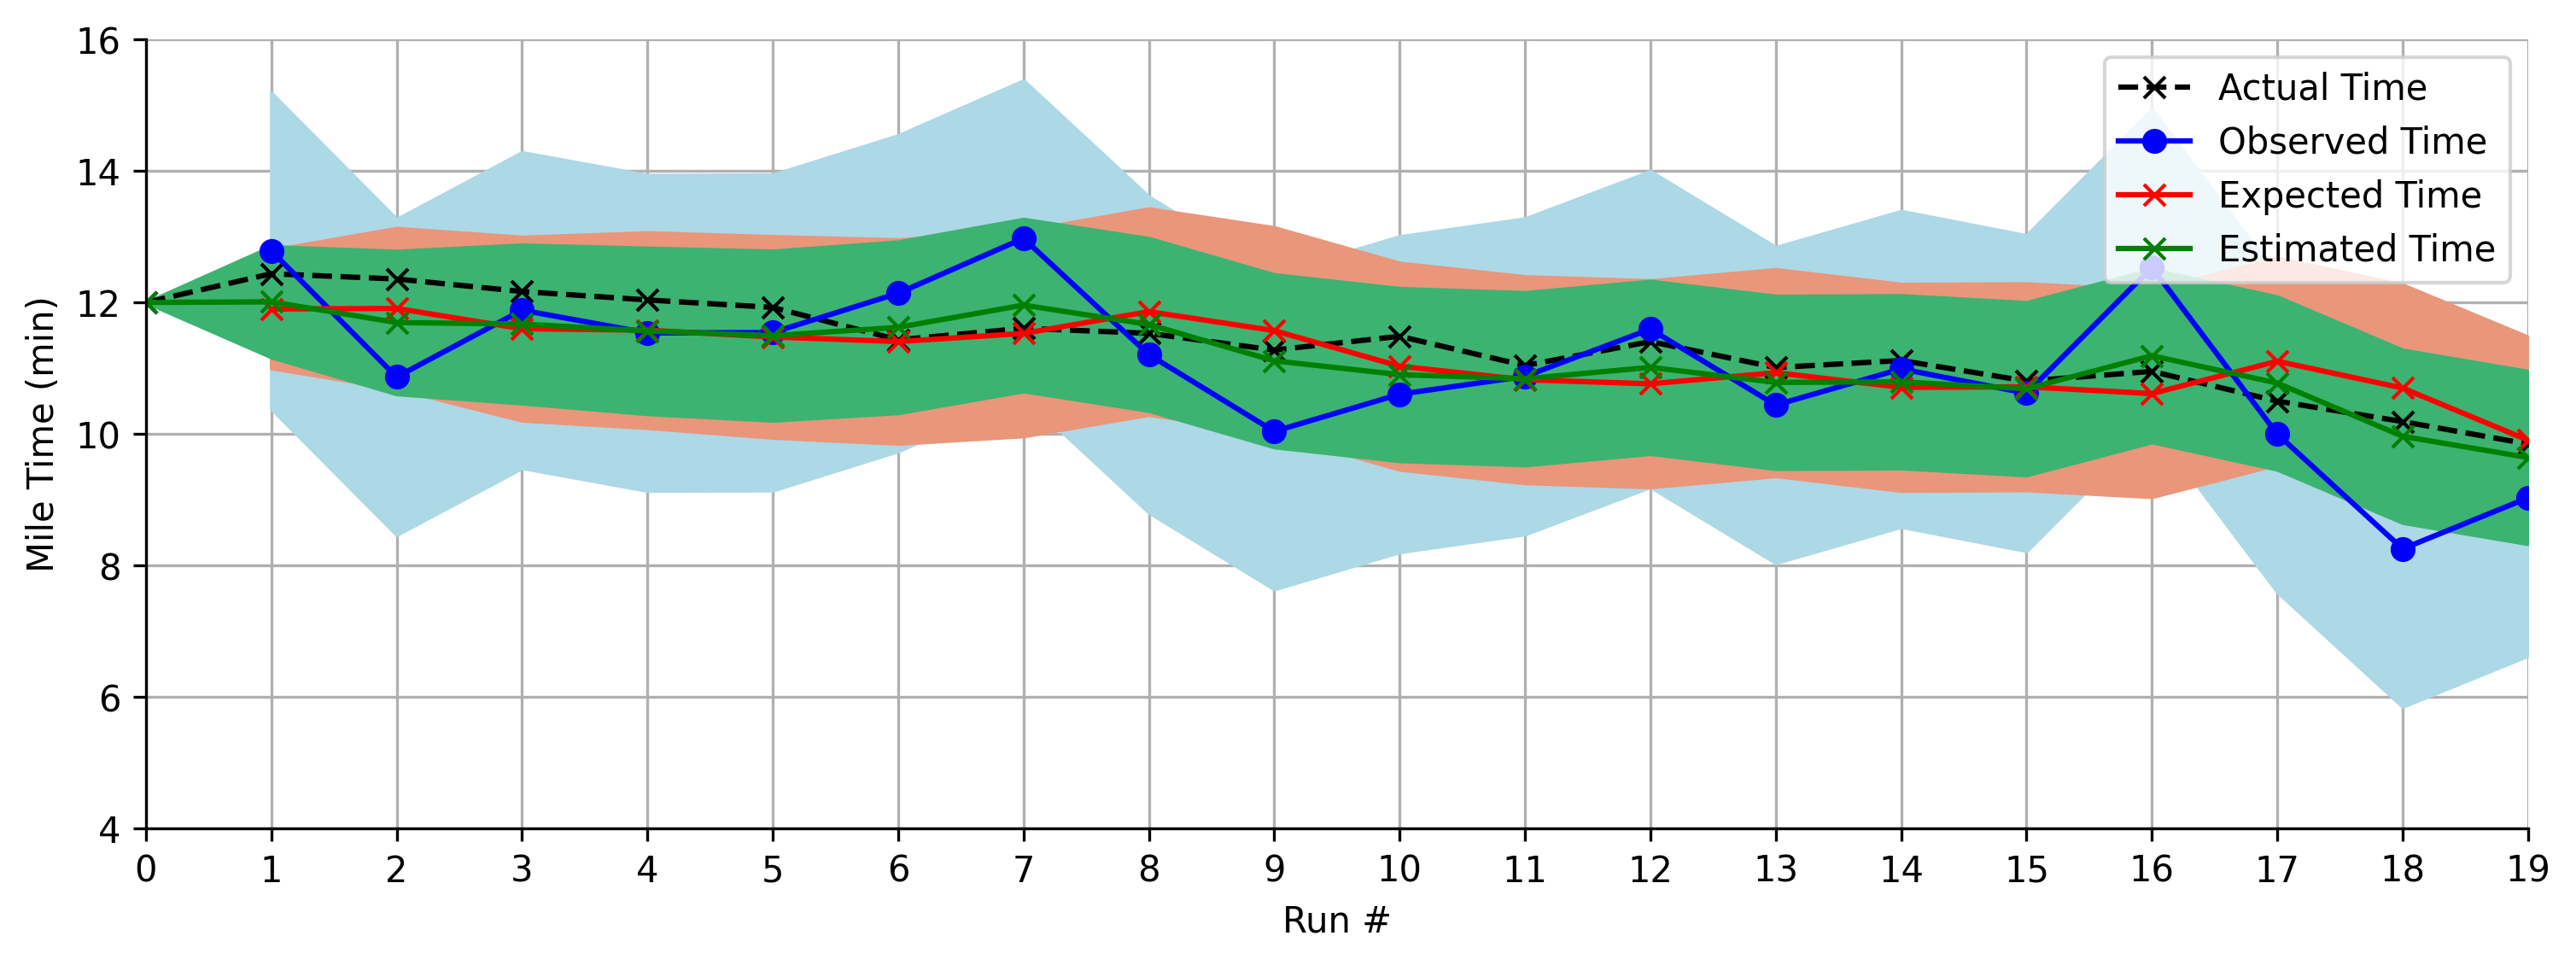

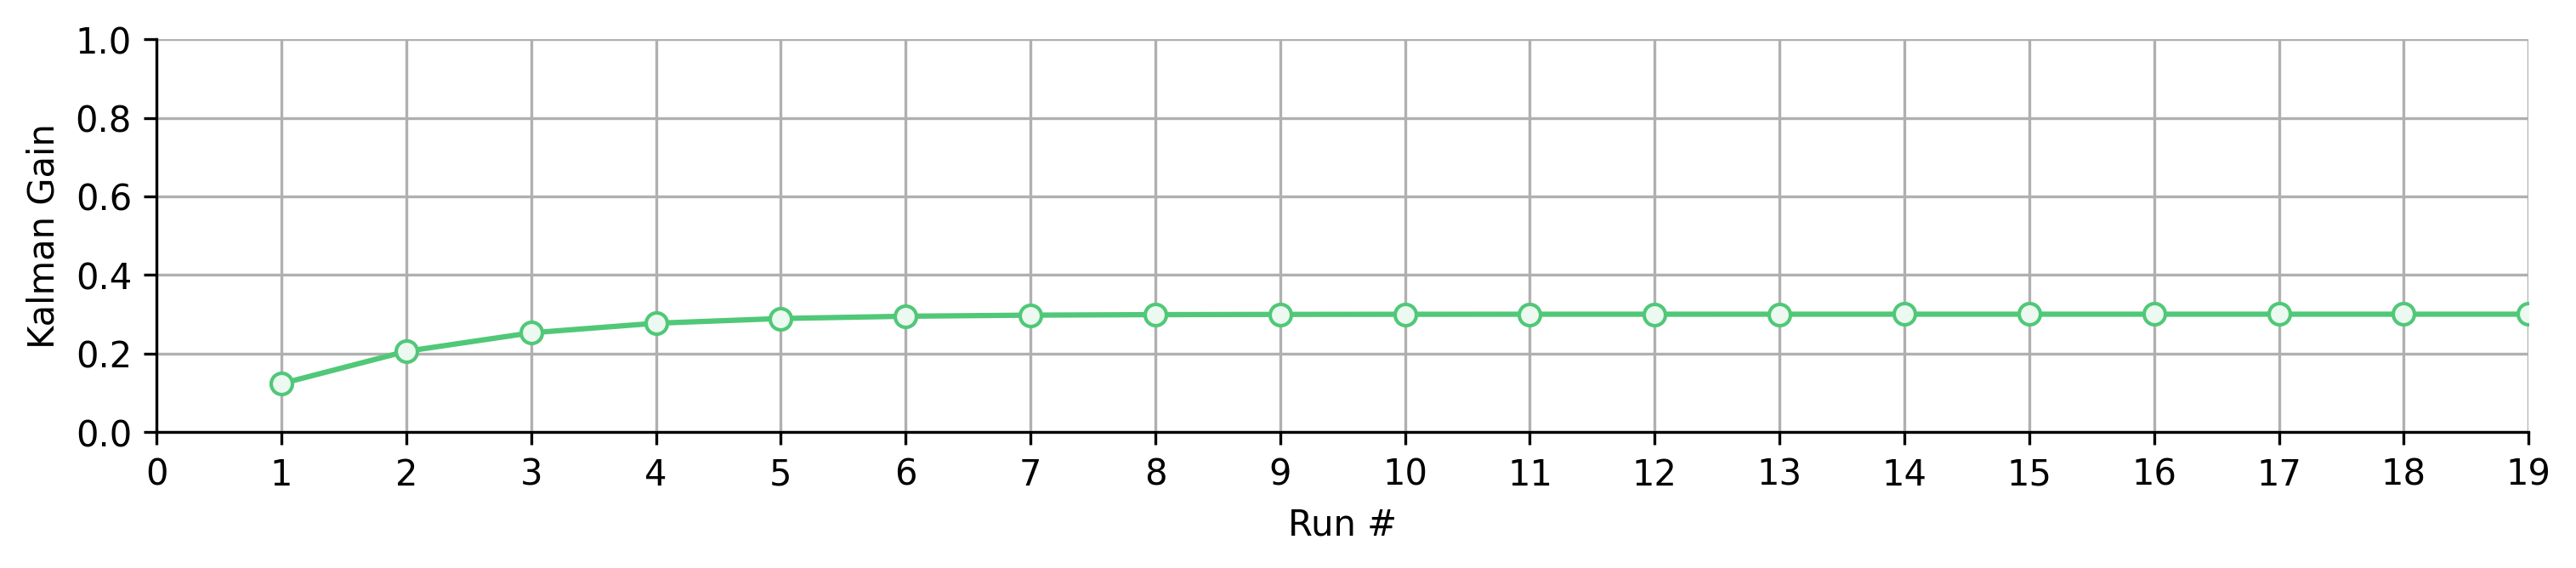

In [3]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=300)
stds = 3
alpha = 1
ax.plot(
    range(STEPS),
    actual_state + MIN_TIME,
    marker="x",
    linestyle="--",
    color="black",
    label="Actual Time",
)

ax.plot(
    np.arange(STEPS - 1) + 1,
    obs[1:] + MIN_TIME,
    marker="o",
    linestyle="-",
    color="blue",
    label="Observed Time",
)
ax.fill_between(
    np.arange(STEPS - 1) + 1,
    obs[1:] + meas_std * stds + MIN_TIME,
    obs[1:] - meas_std * stds + MIN_TIME,
    color="lightblue",
    alpha=alpha,
)

ax.plot(
    np.arange(STEPS - 1) + 1,
    expected_state[1:] + MIN_TIME,
    marker="x",
    linestyle="-",
    color="red",
    label="Expected Time",
)
ax.fill_between(
    np.arange(STEPS - 1) + 1,
    expected_state[1:] + expected_state_std[1:] * stds + MIN_TIME,
    expected_state[1:] - expected_state_std[1:] * stds + MIN_TIME,
    color="DarkSalmon",
    alpha=alpha,
)

ax.plot(
    np.arange(STEPS),
    estimated_state + MIN_TIME,
    marker="x",
    linestyle="-",
    color="green",
    label="Estimated Time",
)
ax.fill_between(
    np.arange(STEPS),
    estimated_state + estimated_state_std * stds + MIN_TIME,
    estimated_state - estimated_state_std * stds + MIN_TIME,
    color="MediumSeaGreen",
    alpha=alpha,
)

ax.legend(loc="upper right")
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_xlim(0, STEPS - 1)
ax.set_xticks(range(STEPS))
ax.set_ylim(4, 16)
ax.grid()
ax.set_xlabel("Run #")
ax.set_ylabel("Mile Time (min)")
ax.set_axisbelow(True)
plt.show()

fig, ax = plt.subplots(figsize=(12, 2), dpi=300)
ax.plot(
    np.arange(STEPS - 1) + 1,
    gain[1:],
    linestyle="-",
    marker="o",
    color="#50C878",
    markerfacecolor="#ecf9f0",
)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_xlim(0, STEPS - 1)
ax.set_ylim(0, 1)
ax.set_xticks(range(STEPS))
ax.grid()
ax.set_xlabel("Run #")
ax.set_ylabel("Kalman Gain")
plt.show()


In [4]:
df = pd.DataFrame(
    {
        "Observed Time": obs,
        "Model Output": expected_state,
        "Model Variance": expected_state_std**2,
        "Kalman Gain": gain,
        "Estimated True Time": estimated_state,
        "Estimated Squared Error": estimated_state_std**2,
    }
)
df.index = df.index.rename("Step")
df.style.format(precision=2)

,Observed Time,Model Output,Model Variance,Kalman Gain,Estimated True Time,Estimated Squared Error
Step,,,,,,
0,0.00,0.00,0.00,0.00,5.00,0.00
1,5.79,4.90,0.09,0.12,5.01,0.08
2,3.87,4.91,0.17,0.21,4.69,0.13
3,4.88,4.60,0.22,0.25,4.67,0.16
4,4.54,4.58,0.25,0.28,4.57,0.18
5,4.54,4.48,0.26,0.29,4.49,0.19
6,5.14,4.41,0.27,0.29,4.62,0.19
7,5.98,4.53,0.27,0.30,4.96,0.19
8,4.21,4.86,0.27,0.30,4.66,0.19
